In [2]:
from pathlib import Path
from typing import Any
from logging import INFO, DEBUG
import json
import os
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from scipy.signal import medfilt
from flwr.common import log, ndarrays_to_parameters
import matplotlib.pyplot as plt
import math
import torch
from src.common.client_utils import (
    load_femnist_dataset,
    get_network_generator_cnn as get_network_generator,
    get_device,
    get_model_parameters,
    aggregate_weighted_average,
)


from src.flwr_core import (
    set_all_seeds,
    get_paths,
    decompress_dataset,
    get_flower_client_generator,
    sample_random_clients,
    get_federated_evaluation_function,
)

from src.estimate import (
    compute_critical_batch,
)

from src.experiments_simulation import (
    run_simulation,
    centralized_experiment,
    centralized_critical_bs_estimation
)

from src.utils import get_centralized_acc_from_hist

PathType = Path | str | None

set_all_seeds()

PATHS = get_paths()

HOME_DIR = PATHS["home_dir"]
DATASET_DIR = PATHS["dataset_dir"]
DATA_DIR = PATHS["data_dir"]
CENTRALIZED_PARTITION = PATHS["centralized_partition"]
CENTRALIZED_MAPPING = PATHS["centralized_mapping"]
FEDERATED_PARTITION = PATHS["federated_partition"]

# extract dataset from tar.gz
decompress_dataset(PATHS)

NETWORK_GENERATOR = get_network_generator()
SEED_NET = NETWORK_GENERATOR()
SEED_MODEL_PARAMS = get_model_parameters(SEED_NET)
CID_CLIENT_GENERATOR = get_flower_client_generator(NETWORK_GENERATOR, FEDERATED_PARTITION)


centralized_train_dataset = load_femnist_dataset(data_dir=DATA_DIR,mapping=CENTRALIZED_MAPPING, name="train")
centralized_test_dataset = load_femnist_dataset(data_dir=DATA_DIR, mapping=CENTRALIZED_MAPPING, name="test")

centralized_train_config = {
    "epochs": 10,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0,
    "num_workers": 0,
    "max_batches": 100,
}

centralized_test_config = {
    "batch_size": 32,
    "num_workers": 0,
    "max_batches": 100,
    "target_accuracy": 0.60,
}

### Estimating Critical batch size in a Centralized Setting 

This part estimates critical bs by using gradient accumulation.

In [2]:
all_B_simples = []

centralized_experiment_batch_sizes = [16, 32, 64, 128, 256]
for batch_size in centralized_experiment_batch_sizes:
    print("Runing experiment with batch size: ", batch_size)

    train_cfg = centralized_train_config.copy()
    train_cfg["batch_size"] = batch_size
    ratio = np.sqrt(batch_size / 256)
    train_cfg["learning_rate"] = ratio * 0.1

    test_cfg = centralized_test_config.copy()
    test_cfg["batch_size"] = batch_size

    # Create DataLoaders with the same settings.
    centralized_train_loader = DataLoader(
        dataset=centralized_train_dataset,
        batch_size=train_cfg["batch_size"],
        shuffle=True,                # Shuffle for training
        num_workers=train_cfg["num_workers"],
        drop_last=True,              # If FL training drops last batch, do the same here.
    )

    centralized_test_loader = DataLoader(
        dataset=centralized_test_dataset,
        batch_size=test_cfg["batch_size"],
        shuffle=False,               # No shuffling during evaluation
        num_workers=test_cfg["num_workers"],
        drop_last=False,
    )
    
    B_simples_per_epochs = centralized_critical_bs_estimation(train_cfg, test_cfg, centralized_train_loader, centralized_test_loader, get_device(), NETWORK_GENERATOR(), accumulation_steps=16)
    all_B_simples.append(B_simples_per_epochs)
    print("B_simples_per_epochs: ", B_simples_per_epochs)



Runing experiment with batch size:  16
B_simples_per_epochs:  [tensor(3272.3811, device='cuda:0'), tensor(74.4693, device='cuda:0'), tensor(1698.8645, device='cuda:0'), tensor(-635.1680, device='cuda:0'), tensor(120.8173, device='cuda:0'), tensor(-1883.0592, device='cuda:0'), tensor(2086.1748, device='cuda:0'), tensor(59.0383, device='cuda:0'), tensor(129.7844, device='cuda:0'), tensor(63.8770, device='cuda:0')]
Runing experiment with batch size:  32
B_simples_per_epochs:  [tensor(116.3740, device='cuda:0'), tensor(351.0595, device='cuda:0'), tensor(75.8703, device='cuda:0'), tensor(15.5538, device='cuda:0'), tensor(164.6863, device='cuda:0'), tensor(73.9510, device='cuda:0'), tensor(602.7814, device='cuda:0'), tensor(308.1201, device='cuda:0'), tensor(655.1780, device='cuda:0'), tensor(133.0237, device='cuda:0')]
Runing experiment with batch size:  64
B_simples_per_epochs:  [tensor(318.7977, device='cuda:0'), tensor(29.9809, device='cuda:0'), tensor(297.0883, device='cuda:0'), tensor(

In [3]:
# for easier plotting we cached results
all_B_simples = [
    [torch.tensor(3272.3811, device='cuda:0'), torch.tensor(74.4693, device='cuda:0'), torch.tensor(1698.8645, device='cuda:0'), torch.tensor(-635.1680, device='cuda:0'), torch.tensor(120.8173, device='cuda:0'), torch.tensor(-1883.0592, device='cuda:0'), torch.tensor(2086.1748, device='cuda:0'), torch.tensor(59.0383, device='cuda:0'), torch.tensor(129.7844, device='cuda:0'), torch.tensor(63.8770, device='cuda:0')],
    [torch.tensor(116.3740, device='cuda:0'), torch.tensor(351.0595, device='cuda:0'), torch.tensor(75.8703, device='cuda:0'), torch.tensor(15.5538, device='cuda:0'), torch.tensor(164.6863, device='cuda:0'), torch.tensor(73.9510, device='cuda:0'), torch.tensor(602.7814, device='cuda:0'), torch.tensor(308.1201, device='cuda:0'), torch.tensor(655.1780, device='cuda:0'), torch.tensor(133.0237, device='cuda:0')],
    [torch.tensor(318.7977, device='cuda:0'), torch.tensor(29.9809, device='cuda:0'), torch.tensor(297.0883, device='cuda:0'), torch.tensor(333.3126, device='cuda:0'), torch.tensor(264.8666, device='cuda:0'), torch.tensor(4091.6382, device='cuda:0'), torch.tensor(1919.4056, device='cuda:0'), torch.tensor(326.9816, device='cuda:0'), torch.tensor(244.9464, device='cuda:0'), torch.tensor(175.2559, device='cuda:0')],
    [torch.tensor(58.6747, device='cuda:0'), torch.tensor(2070.6477, device='cuda:0'), torch.tensor(656.6006, device='cuda:0'), torch.tensor(1091.5375, device='cuda:0'), torch.tensor(878.4341, device='cuda:0'), torch.tensor(684.2392, device='cuda:0'), torch.tensor(745.6109, device='cuda:0'), torch.tensor(220.5739, device='cuda:0'), torch.tensor(285.9246, device='cuda:0'), torch.tensor(4479.2437, device='cuda:0')],
    [torch.tensor(251.7003, device='cuda:0'), torch.tensor(391.6642, device='cuda:0'), torch.tensor(341.3409, device='cuda:0'), torch.tensor(439.4055, device='cuda:0'), torch.tensor(669.5894, device='cuda:0'), torch.tensor(729.9749, device='cuda:0'), torch.tensor(573.2344, device='cuda:0'), torch.tensor(748.9799, device='cuda:0'), torch.tensor(575.9369, device='cuda:0'), torch.tensor(352.2092, device='cuda:0')]
]

In [4]:
all_B_simples = [[abs(el).cpu().numpy() for el in subl] for subl in all_B_simples]
all_B_simples = [[el for el in subl] for subl in all_B_simples]
all_B_simples = [medfilt(subl, 5) for subl in all_B_simples]

393.534


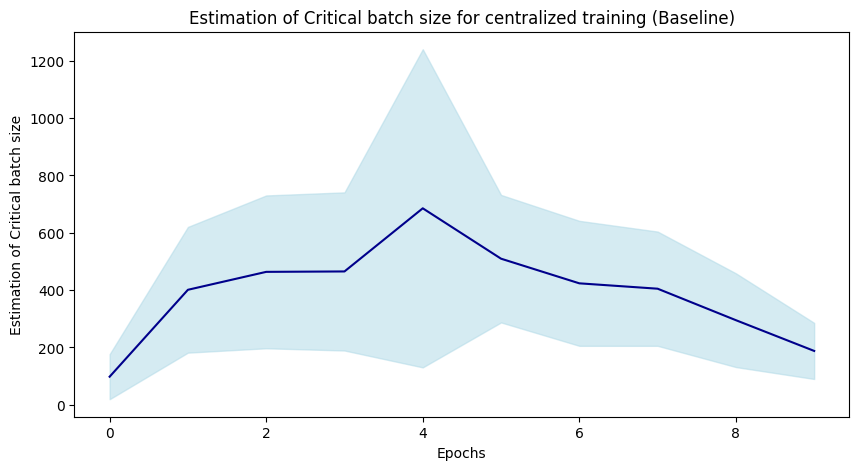

Final Critical batch size Estimate:  414.3777


In [5]:
epochs = 10

mean_t = [np.mean([all_B_simples[run][i] for run in range(len(all_B_simples)) if i < len(all_B_simples[run])]) for i in range(epochs)]
std_t = [np.std([all_B_simples[run][i] for run in range(len(all_B_simples)) if i < len(all_B_simples[run])]) for i in range(epochs)]

mean_t = np.array(mean_t)

print(np.mean(mean_t)) # 108600
std_t = np.array(std_t)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(mean_t, color='darkblue')
ax.fill_between(range(epochs), mean_t - std_t, mean_t + std_t, color='lightblue', alpha=0.5)
ax.set_xlabel('Epochs')
ax.set_ylabel('Estimation of Critical batch size')
ax.set_title('Estimation of Critical batch size for centralized training (Baseline)')
plt.show()
out_dir = os.path.join(os.getcwd(), 'plots')
os.makedirs(out_dir, exist_ok=True)
fig.savefig(os.path.join(out_dir, 'critical_bs_estimation_baseline.png'), dpi=300)


print("Final Critical batch size Estimate: ", np.median(mean_t))



In [7]:
bs_critical_estimate = np.median(mean_t)

In [6]:
def get_git_root():
    import subprocess
    try:
        git_root = subprocess.check_output(['git', 'rev-parse', '--show-toplevel'], 
                                         stderr=subprocess.DEVNULL)
        return git_root.decode('utf-8').strip()
    except subprocess.CalledProcessError:
        return os.getcwd()  # Fallback to current directory if not in a git repo


/home/pp608/src/L361-FL-project


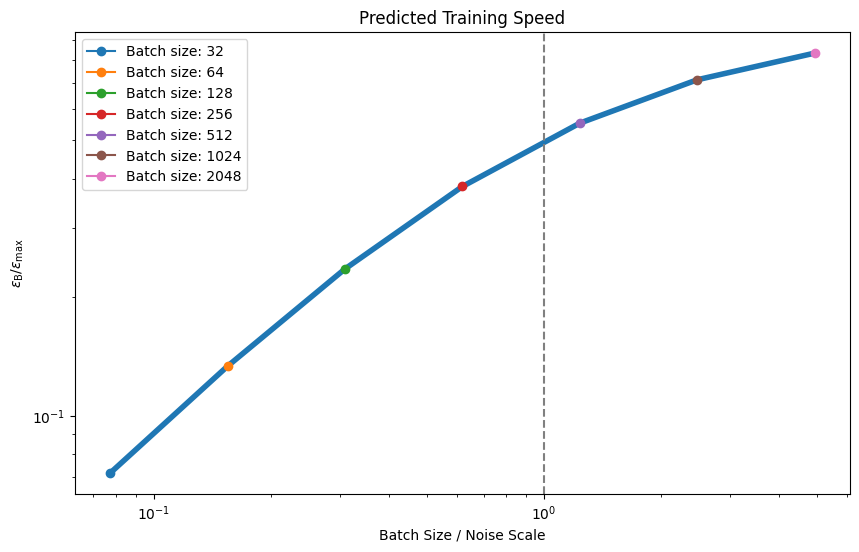

In [ ]:
def load_experiment(filename):
    with open(filename, "r") as f:
        return json.load(f)


centralized_experiment_batch_sizes = [32, 64, 128, 256, 512, 1024, 2048]

project_root = get_git_root()
print(project_root)
save_dir = os.path.join(project_root, "plots", "centralized")
os.makedirs(save_dir, exist_ok=True)

x_vals = []
y_vals = []
centralized_experiment_results = [
    (batch_size, load_experiment(os.path.join(project_root, "results", f"centralized_experiment_results_{batch_size}.json")))
    for batch_size in centralized_experiment_batch_sizes
]


accuracy_thresholds = [0.4, 0.5, 0.6]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green

fig, ax = plt.subplots(figsize=(10, 6))
# Right subplot: Noise Scale vs. Cumulative Training Time for each batch size
for batch_size, results in centralized_experiment_results:
    noise_scale = bs_critical_estimate

    x_axis = batch_size / noise_scale
    y_axis = 1 / (1 + (noise_scale / batch_size))
    x_vals.append(x_axis)
    y_vals.append(y_axis)
    ax.plot(x_axis, y_axis, marker='o', label=f"Batch size: {batch_size}")



ax.axvline(x=1, color='gray', linestyle='--')
ax.plot(x_vals, y_vals, linestyle='-', color='#1f77b4', linewidth=4, zorder=0)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("Batch Size / Noise Scale")
ax.set_ylabel(fr"${{\epsilon_\text{{B}}}} / {{\epsilon_\text{{max}}}}$")
ax.set_title("Predicted Training Speed")
fig.savefig(os.path.join(save_dir, 'lr_scaling_centralized.png'), dpi=300)
ax.legend()
